# Animals 10
Made by Samuel Tvrdoň and Michal Weis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Dataset

In [2]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import v2
from torchvision import datasets
from torch.utils.data import DataLoader
import shutil
import wandb
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
def make_data_frame(path):
  data = []
  for animal_class in path.iterdir():
    if animal_class.is_dir():
      for img in animal_class.glob("*"):
        data.append({"label": animal_class.name, "path": str(img)})

  return pd.DataFrame(data)

In [4]:
src_root = Path('/content/drive/MyDrive/ZNEUS/dataset/raw-img')
df = make_data_frame(src_root)

## EDA

In [5]:
df.head()

,label,path
0,cow,/content/drive/MyDrive/ZNEUS/dataset/raw-img/c...
1,cow,/content/drive/MyDrive/ZNEUS/dataset/raw-img/c...
2,cow,/content/drive/MyDrive/ZNEUS/dataset/raw-img/c...
3,cow,/content/drive/MyDrive/ZNEUS/dataset/raw-img/c...
4,cow,/content/drive/MyDrive/ZNEUS/dataset/raw-img/c...


In [6]:
df.tail()

,label,path
26174,squirrel,/content/drive/MyDrive/ZNEUS/dataset/raw-img/s...
26175,squirrel,/content/drive/MyDrive/ZNEUS/dataset/raw-img/s...
26176,squirrel,/content/drive/MyDrive/ZNEUS/dataset/raw-img/s...
26177,squirrel,/content/drive/MyDrive/ZNEUS/dataset/raw-img/s...
26178,squirrel,/content/drive/MyDrive/ZNEUS/dataset/raw-img/s...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   26179 non-null  object
 1   path    26179 non-null  object
dtypes: object(2)
memory usage: 409.2+ KB


In [8]:
df.describe()

,label,path
count,26179,26179
unique,10,26179
top,dog,/content/drive/MyDrive/ZNEUS/dataset/raw-img/s...
freq,4863,1


Our dataset contains 26209 pictures of 10 different animals. The most number of sample images are for the class dog. We will visualise the distribution of the whole dataset

Total images: 26179


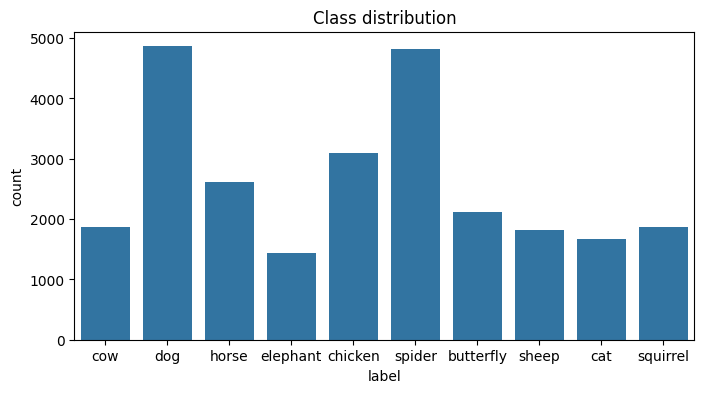

In [9]:
print("Total images:", len(df))

plt.figure(figsize=(8,4))
sns.countplot(x='label', data=df)
plt.title("Class distribution")
plt.show()

We can see that spider and dog images are the most abundant, while the counts for other animals are mostly the same.

TODO: does checking for missing and duplicate rows make sense?\
Next we will check if we have any corrupted files

<b> TOO LONG </b>

In [10]:
# from PIL import UnidentifiedImageError
# from tqdm import tqdm

# # Check if all images are valid
# bad_images = []
# for path in tqdm(df['path']):
#     try:
#         Image.open(path).verify()
#     except UnidentifiedImageError:
#         bad_images.append(path)

# print("Number of bad images:", len(bad_images))

To verify image quality we will inspect random images from each class.

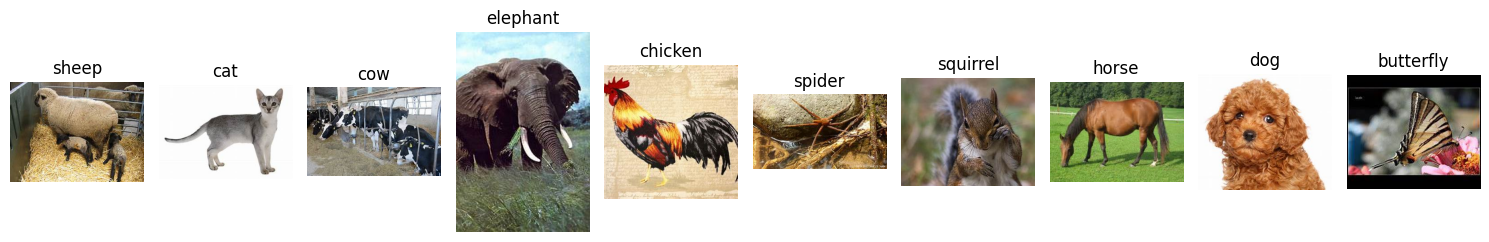

In [11]:
fig, axes = plt.subplots(1, 10, figsize=(15,3))
classes = df['label'].unique()

for i, c in enumerate(random.sample(list(classes), k=10)):
    sample_path = random.choice(df[df['label']==c]['path'].values)
    img = Image.open(sample_path)
    axes[i].imshow(img)
    axes[i].set_title(c)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Experiment Setup

In [12]:
config = {
    "batch_size": 32,
    "learning_rate": 0.0003,
    "epochs": 30
}

In [13]:
def get_metrics(total_loss, batch_count, preds, ys):
    # TODO: clean up
    # Average loss in the given epoch
    avg_loss = total_loss / batch_count

    accuracy = accuracy_score(ys, preds)

    # For multi-class classification, use 'weighted' average for f1_score
    # f1 = f1_score(ys, predicted_classes, average='weighted')
    # precision = precision_score(ys, predicted_classes, average='weighted')
    # recall = recall_score(ys, predicted_classes, average='weighted')

    return {
        "loss": avg_loss,
        "accuracy": accuracy,
        # "f1_score": f1,
        # "precision": precision,
        # "recall": recall
    }

## Data split

We need to split the data before starting with the preprocessing and augmentation. We opted for a 70-30 split, creating a new split folder storing both training and validation data.

In [14]:
# Set new folder locations
split_root = Path('/content/drive/MyDrive/ZNEUS/dataset/split')
train_root = split_root / 'train'
val_root = split_root / 'val'

# # Create new folders
# train_root.mkdir(parents=True, exist_ok=True)
# val_root.mkdir(parents=True, exist_ok=True)

# # Set split ration
# ratio = 0.7
# random.seed(23)

# for animal_class in src_root.iterdir():
#   if animal_class.is_dir():
#     images = [p for p in animal_class.glob("*") if p.is_file()]
#     random.shuffle(images)

#     n_train = int(len(images) * ratio)

#     train_images = images[:n_train]
#     val_images = images[n_train:]

#     # Destination folders for current class
#     train_class_dir = train_root / animal_class.name
#     val_class_dir = val_root / animal_class.name
#     train_class_dir.mkdir(parents=True, exist_ok=True)
#     val_class_dir.mkdir(parents=True, exist_ok=True)

#     # Copy images to destination
#     for img in train_images:
#       shutil.copy(img, train_class_dir / img.name)

#     for img in val_images:
#       shutil.copy(img, val_class_dir / img.name)

We will make sure the split worked as intended.

Total images: 18322


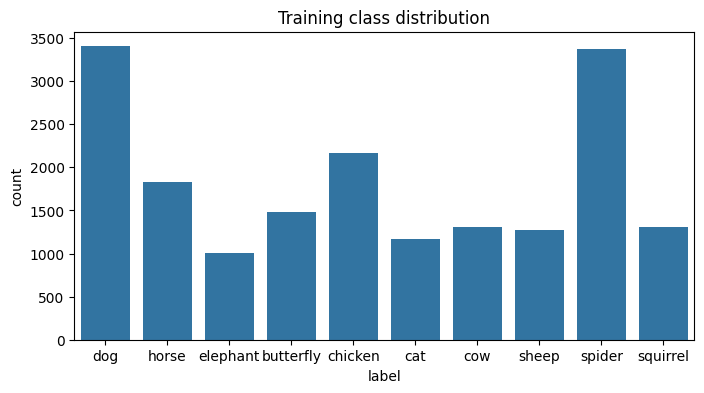

In [15]:
train_df = make_data_frame(train_root)
print("Total images:", len(train_df))

plt.figure(figsize=(8,4))
sns.countplot(x='label', data=train_df)
plt.title("Training class distribution")
plt.show()

Total images: 7857


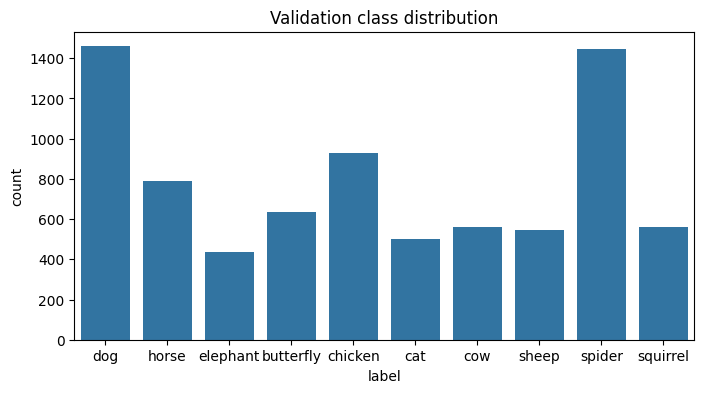

In [16]:
val_df = make_data_frame(val_root)
print("Total images:", len(val_df))

plt.figure(figsize=(8,4))
sns.countplot(x='label', data=val_df)
plt.title("Validation class distribution")
plt.show()


## Image preprocessing and augmentations


In [17]:
# Training dataset
train_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(0.5),
    v2.RandomRotation(15),
    v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(
    root=train_root,
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
)

# Validation dataset
val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(
    root=val_root,
    transform=val_transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
)

## Model
We define our model.

In [18]:
class AnimalModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Conv2d(3, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            # TODO: check how the shape changes throughout the pipeline
            nn.Linear(16 * 54 * 54, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.stack(x)

## Training
We begin trainig.

In [19]:
# Init wandb
with wandb.init(project="zneus-2", config=config) as run:
  model = AnimalModel()
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print(f"Running on {device}")
  model.to(device)

  # TODO: check other loss functions?
  loss_fn = nn.CrossEntropyLoss()

  # TODO:
  optimizer = torch.optim.Adam(params=model.parameters(), lr=config["learning_rate"])

  # Log both parameters and gradient
  run.watch(model, criterion=loss_fn, log_freq=100, log="all")

  # Start training
  for epoch_idx in range(config["epochs"]):
      print(f"Epoch {epoch_idx + 1}\n-------------------------------")

      # Train
      train_total_loss = 0
      train_preds = []
      train_ys = []

      model.train()
      for X, y in train_loader:
        # TODO: the training is super slow 💀💀💀💀
          print("batch")
          # Move to device
          X = X.to(device)
          y = y.to(device)

          # Predict
          pred = model(X)
          loss = loss_fn(pred, y)

          # Optimize
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          # Save values
          train_total_loss += loss.item()
          train_preds.extend(torch.argmax(pred).detach().cpu().numpy().ravel())
          train_ys.extend(y.detach().cpu().numpy().ravel())

      train_metrics = get_metrics(
          train_total_loss, len(train_loader), train_preds, train_ys
      )
      print("Training:")
      for k, v in train_metrics.items():
          print(f"{k}: {v}")
      print()

      # Validate
      val_total_loss = 0
      val_preds = []
      val_ys = []

      model.eval()
      with torch.no_grad():
          for X, y in val_loader:
              # Move to device
              X = X.to(device)
              y = y.to(device)

              # Predict
              pred = model(X)
              loss = loss_fn(pred, y)

              # Save values
              val_total_loss += loss.item()
              val_preds.extend(torch.argmax(pred).detach().cpu().numpy().ravel())
              val_ys.extend(y.detach().cpu().numpy().ravel())


      val_metrics = get_metrics(
          val_total_loss, len(val_loader), val_preds, val_ys
      )
      print("Validation:")
      for k, v in val_metrics.items():
          print(f"{k}: {v}")
      print()

      # Wandb logging
      run.log(
          {
              **{f"train_{k}": v for k, v in train_metrics.items()},
              **{f"val_{k}": v for k, v in val_metrics.items()},
          }
      )

  # TODO: add test set


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:



KeyboardInterrupt: 